<a href="https://colab.research.google.com/github/kjasmine-git/text_summarization_topsis/blob/main/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 wh

In [ ]:
import numpy as np
import pandas as pd
import nltk
from transformers import pipeline
from datasets import load_dataset

In [ ]:
# Load a Dataset from Hugging Face
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:1000]")

# Define Pre-Trained Summarization Models
summarization_models = {
    "M1": "facebook/bart-large-cnn",
    "M2":  "t5-small",
    "M3": "Falconsai/text_summarization",
    "M4": "sshleifer/distilbart-cnn-12-6"
}

In [ ]:
# Function to Summarize Text
def summarize_text(model_name, text):
    summarizer = pipeline("summarization", model=summarization_models[model_name])
    summary = summarizer(text, max_length=150, min_length=50, do_sample=False, truncation=True)
    return summary[0]["summary_text"]

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
rouge = Rouge()
# Function to Evaluate Summary
def evaluate_summary(original_text, summary_text):
    result = rouge.get_scores(hyps=[summary_text], refs=[original_text])[0]
    return {
        "P1": result["rouge-1"]["f"],  # ROUGE-1
        "P2": result["rouge-2"]["f"],  # ROUGE-2
        "P3": result["rouge-l"]["f"],  # ROUGE-L
        "P4": len(summary_text) / len(original_text)  # Compression Ratio
    }

In [ ]:
def apply_topsis(models, data):
    data = np.array(data)  # Convert list of lists to NumPy array
    weights = np.array([0.4, 0.3, 0.2, 0.1])  # Importance of each criterion
    impacts = np.array(["+", "+", "+", "-"])  # Higher is better for ROUGE; lower for Compression

    # Normalize the decision matrix
    norm_data = data / np.sqrt((data ** 2).sum(axis=0))

    # Calculate weighted normalized decision matrix
    weighted_data = norm_data * weights

    # Identify ideal best and worst solutions
    ideal_best = np.where(impacts == "+", weighted_data.max(axis=0), weighted_data.min(axis=0))
    ideal_worst = np.where(impacts == "+", weighted_data.min(axis=0), weighted_data.max(axis=0))
    # Calculate distances from ideal best and worst
    distance_best = np.sqrt(((weighted_data - ideal_best) ** 2).sum(axis=1))
    distance_worst = np.sqrt(((weighted_data - ideal_worst) ** 2).sum(axis=1))

    # Calculate TOPSIS scores
    topsis_scores = distance_worst / (distance_best + distance_worst)

    # Rank the models
    ranks = topsis_scores.argsort()[::-1] + 1  # Higher score = better rank

    return topsis_scores, ranks


In [ ]:
results = []

# Process 5 random texts
for i in range(5):
    sample = dataset[i]
    text = sample["article"]
    reference_summary = sample["highlights"]
    evaluation_data = []
    model_names = []

    for model in summarization_models.keys():
        summary = summarize_text(model, text)
        metrics = evaluate_summary(reference_summary, summary)
        evaluation_data.append(list(metrics.values()))
        model_names.append(model)

    topsis_scores,ranks = apply_topsis(model_names, evaluation_data)

    for j, model in enumerate(model_names):
        results.append([f"T{i+1}", model, *evaluation_data[j], topsis_scores[j], ranks[j]])

# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=["Text", "Model", "P1", "P2", "P3", "P4", "Topsis Score", "Rank"])

# Print results
print(df_results)



Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Asking to truncate to max_length but no maximum length is prov

   Text Model        P1        P2        P3        P4  Topsis Score  Rank
0    T1    M1  0.416667  0.289157  0.416667  1.476395      0.777348     4
1    T1    M2  0.281250  0.189189  0.281250  1.330472      0.161072     1
2    T1    M3  0.260870  0.151899  0.260870  1.296137      0.039464     2
3    T1    M4  0.468750  0.315789  0.468750  1.334764      0.991277     3
4    T2    M1  0.375000  0.253165  0.375000  1.028037      0.951519     1
5    T2    M2  0.317460  0.055556  0.317460  0.789720      0.135911     4
6    T2    M3  0.301370  0.046512  0.273973  1.158879      0.038396     2
7    T2    M4  0.368421  0.147368  0.315789  1.345794      0.496903     3
8    T3    M1  0.338028  0.150000  0.338028  1.311927      0.979291     4
9    T3    M2  0.084507  0.026667  0.084507  1.220183      0.013459     1
10   T3    M3  0.208955  0.084507  0.208955  1.169725      0.483237     3
11   T3    M4  0.338028  0.150000  0.338028  1.307339      0.979946     2
12   T4    M1  0.305556  0.121951  0.2

In [ ]:
df_results.to_csv("summarization_results.csv", index=False)

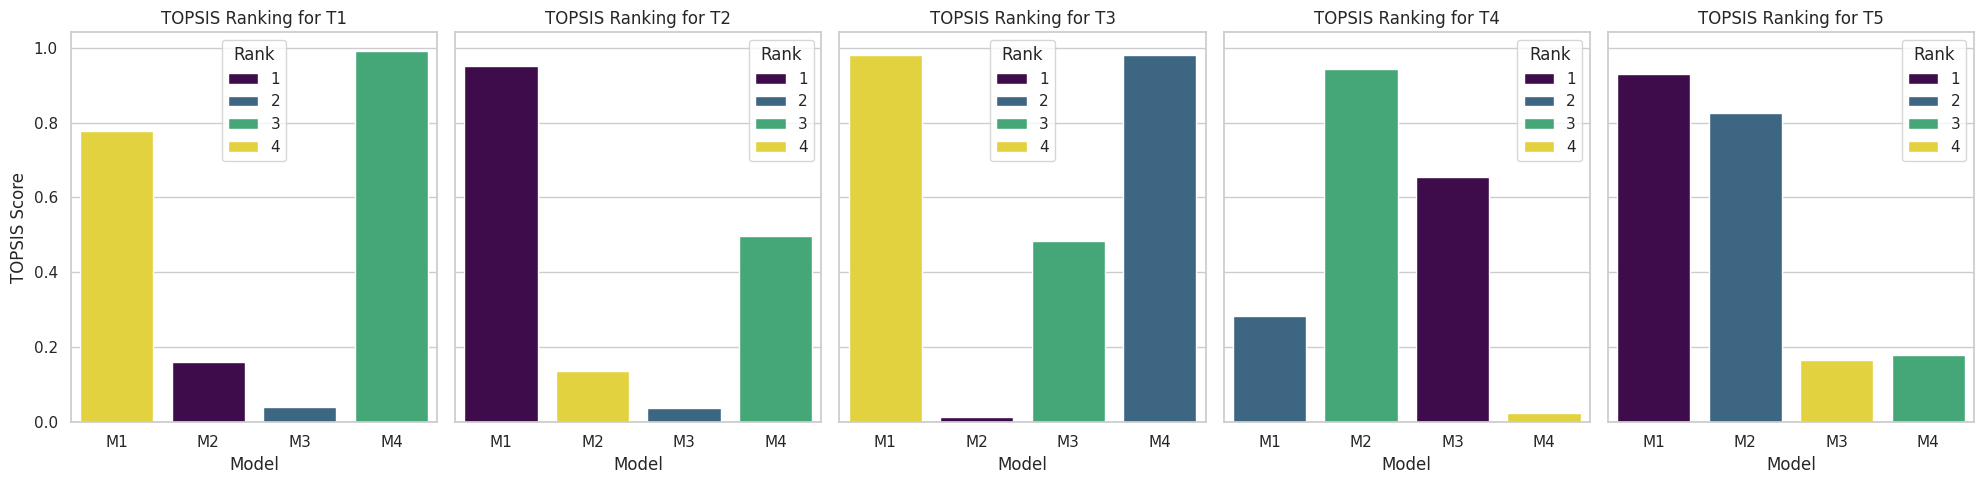

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
texts = df_results["Text"].unique()
for i, text in enumerate(texts):
    ax = axes[i]
    df_subset = df_results[df_results["Text"] == text]
    sns.barplot(x="Model", y="Topsis Score", data=df_subset, palette="viridis", ax=ax, hue="Rank", dodge=False)
    ax.set_title(f"TOPSIS Ranking for {text}")
    ax.set_xlabel("Model")
    ax.set_ylabel("TOPSIS Score" if i == 0 else "")
    ax.legend(title="Rank")

# Show the plot
plt.tight_layout()
plt.show()